In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 70.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 36.3MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 67.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.39MB/s]


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
def loss_without_kl(recon_x, x):
    return nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")

def loss_with_kl(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
latent_dim = 20
model_no_kl = VAE(latent_dim).to(device)
optimizer_no_kl = optim.Adam(model_no_kl.parameters(), lr=1e-3)

epochs = 10
train_losses_no_kl = []

for epoch in range(epochs):
    model_no_kl.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)

        optimizer_no_kl.zero_grad()
        recon, mu, logvar = model_no_kl(data)

        loss = loss_without_kl(recon, data)
        loss.backward()
        optimizer_no_kl.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses_no_kl.append(avg_loss)
    print(f"[NO KL] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


[NO KL] Epoch 1/10, Loss: 132.3911
[NO KL] Epoch 2/10, Loss: 82.3212
[NO KL] Epoch 3/10, Loss: 76.1108
[NO KL] Epoch 4/10, Loss: 73.3808
[NO KL] Epoch 5/10, Loss: 71.6864
[NO KL] Epoch 6/10, Loss: 70.4749
[NO KL] Epoch 7/10, Loss: 69.5407
[NO KL] Epoch 8/10, Loss: 68.8069
[NO KL] Epoch 9/10, Loss: 68.2470
[NO KL] Epoch 10/10, Loss: 67.7803


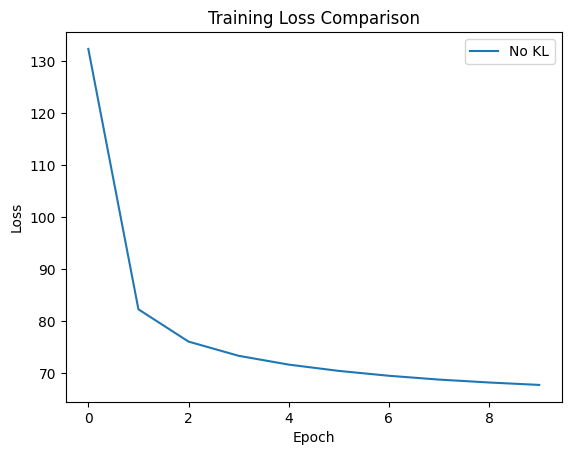

In [8]:
plt.plot(train_losses_no_kl, label="No KL")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# **WITH IMAGE- NO KL DIVERGENCE**

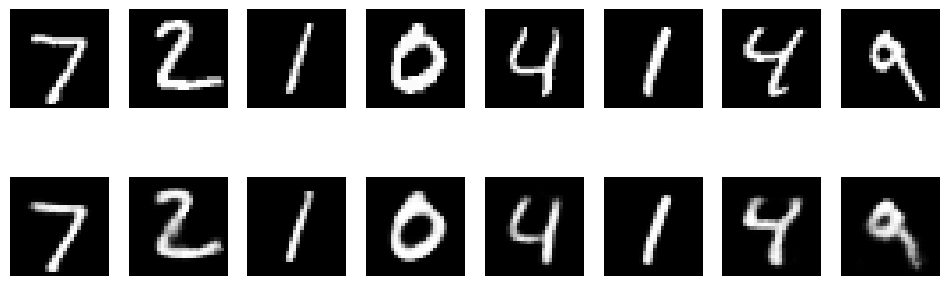

In [9]:
model_no_kl.eval()

data, _ = next(iter(test_loader))
data = data.view(-1, 784).to(device)

with torch.no_grad():
    recon_no_kl, _, _ = model_no_kl(data)

n = 8
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(data[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_no_kl[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

plt.show()


# **WITHOUT IMAGE — NO KL DIVERGENCE**

In [10]:
model_no_kl.eval()

data, _ = next(iter(test_loader))
data = data.view(-1, 784).to(device)

with torch.no_grad():
    recon_no_kl, _, _ = model_no_kl(data)

print("NO KL – Reconstructed tensor (first sample):")
print(recon_no_kl[0])

print("\nShape of output tensor:")
print(recon_no_kl.shape)

print("\nMean value:")
print(recon_no_kl.mean().item())

print("Standard deviation:")
print(recon_no_kl.std().item())


NO KL – Reconstructed tensor (first sample):
tensor([7.6292e-09, 2.0657e-08, 1.2438e-08, 3.9069e-08, 5.4948e-08, 5.0511e-08,
        1.7342e-07, 2.0836e-08, 9.8489e-09, 4.3625e-08, 1.8330e-08, 4.8335e-08,
        1.0725e-08, 9.3786e-11, 9.8987e-11, 2.4264e-08, 7.7362e-08, 1.4531e-08,
        3.4992e-08, 3.4311e-08, 7.0798e-08, 4.9501e-08, 2.8818e-08, 5.0855e-08,
        9.8190e-08, 1.0243e-08, 1.7306e-08, 5.0960e-08, 1.0557e-08, 1.4378e-08,
        5.9429e-09, 2.4164e-08, 2.6820e-08, 4.3605e-08, 5.4259e-07, 1.3583e-07,
        1.0725e-08, 1.0584e-10, 1.5923e-11, 5.8820e-12, 7.9508e-12, 1.8180e-14,
        2.0957e-15, 2.4490e-14, 1.6999e-14, 3.7038e-14, 4.2930e-16, 8.1405e-14,
        6.9506e-13, 6.5004e-12, 9.6424e-10, 6.8672e-09, 2.6923e-08, 5.7077e-08,
        5.0835e-08, 7.2453e-08, 3.6189e-08, 2.0686e-08, 1.2620e-08, 1.8324e-08,
        1.1207e-09, 2.8074e-08, 6.5278e-09, 3.2989e-08, 8.9102e-10, 2.1909e-10,
        4.2406e-11, 2.8622e-13, 1.7402e-15, 1.0416e-16, 1.7813e-15, 2.3054e